# 数据集准备

In [ ]:
import os
import sys
import subprocess
import zipfile
import gdown

# --- 1. 安装 gdown ---
print("正在安装 gdown 库...")
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "gdown"])
print("gdown 安装完成。")

# --- 2. 定义路径和文件ID ---
# 我们将所有内容下载到 /content/ 目录下
output_root = "/content/VisDrone_DATA"
os.makedirs(output_root, exist_ok=True)

# 这是你提供的 Task 5 (人群计数) 数据集的文件ID
file_id = "1HY3V4QObrVjzXUxL_J86oxn2bi7FMUgd"
zip_output_path = os.path.join(output_root, "VisDrone2020-CC.zip")
dataset_final_path = "/content/VisDrone2020-CC" # 解压后的最终路径

# --- 3. 下载文件 ---
print(f"\n开始下载 VisDrone Task 5 (人群计数) 数据集...")
gdown.download(id=file_id, output=zip_output_path, quiet=False)
print("数据集下载完成。")

# --- 4. 解压文件 ---
print(f"\n正在解压文件到 {output_root} ...")
with zipfile.ZipFile(zip_output_path, 'r') as zip_ref:
    zip_ref.extractall(output_root)
print("解压完成。")

# --- 5. 清理和整理文件夹 ---
# 有时候解压后会产生一个多余的顶层文件夹，我们需要处理一下
unzipped_folder_name = "VisDrone2020-CC" # 根据压缩包内的结构，这通常是解压后的文件夹名
unzipped_folder_path = os.path.join(output_root, unzipped_folder_name)

# 如果解压后的文件夹存在，并且最终目标路径（没有output_root前缀）还不存在
if os.path.isdir(unzipped_folder_path) and not os.path.isdir(dataset_final_path):
    print(f"检测到嵌套文件夹，正在将其移动到目标位置: {dataset_final_path}")
    os.rename(unzipped_folder_path, dataset_final_path)
    # 移除现在已经为空的output_root目录
    if not os.listdir(output_root):
        os.rmdir(output_root)
else:
     # 如果没有嵌套文件夹，或者发生了其他情况，我们就重命名
    if os.path.isdir(output_root) and not os.path.isdir(dataset_final_path):
        os.rename(output_root, dataset_final_path)


# --- 6. 清理下载的zip文件 ---
print(f"清理下载的 .zip 文件: {zip_output_path}")
if os.path.exists(zip_output_path):
    os.remove(zip_output_path)

print("\n--- 数据准备完成 ---")
print(f"VisDrone2020-CC 数据集现在位于: {dataset_final_path}")
# 验证一下目录内容
if os.path.exists(dataset_final_path):
    print(f"目录内容: {os.listdir(dataset_final_path)}")
else:
    print(f"错误：最终数据集目录 {dataset_final_path} 未找到！")


正在安装 gdown 库...
gdown 安装完成。

开始下载 VisDrone Task 5 (人群计数) 数据集...


Downloading...
From (original): https://drive.google.com/uc?id=1HY3V4QObrVjzXUxL_J86oxn2bi7FMUgd
From (redirected): https://drive.google.com/uc?id=1HY3V4QObrVjzXUxL_J86oxn2bi7FMUgd&confirm=t&uuid=45d1ec8f-f1a9-4e15-bec6-892c77565a9c
To: /content/VisDrone_DATA/VisDrone2020-CC.zip
100%|██████████| 1.11G/1.11G [00:14<00:00, 76.3MB/s]


数据集下载完成。

正在解压文件到 /content/VisDrone_DATA ...
解压完成。
检测到嵌套文件夹，正在将其移动到目标位置: /content/VisDrone2020-CC
清理下载的 .zip 文件: /content/VisDrone_DATA/VisDrone2020-CC.zip

--- 数据准备完成 ---
VisDrone2020-CC 数据集现在位于: /content/VisDrone2020-CC
目录内容: ['sequences', 'annotations', 'trainlist.txt', 'testlist.txt']


# 预处理

In [ ]:
import os
import shutil
import numpy as np
from scipy.ndimage import gaussian_filter
import h5py
from PIL import Image
from collections import defaultdict
import json
import time

# --- 1. 定义路径 ---
ORIGINAL_DATA_PATH = "/content/VisDrone2020-CC"
PROCESSED_DATA_PATH = "/content/CSRNet-pytorch/preprocessed_VisDrone"

print(f"原始数据集路径: {ORIGINAL_DATA_PATH}")
print(f"处理后数据集将存放于: {PROCESSED_DATA_PATH}")

# --- 2. 快速密度图生成函数 (固定核大小) ---
def fast_gaussian_filter_density(points, map_height, map_width, sigma=4):
    point_map = np.zeros((map_height, map_width), dtype=np.float32)
    for x, y in points:
        if y < map_height and x < map_width:
            point_map[int(y), int(x)] = 1
    density_map = gaussian_filter(point_map, sigma, mode='constant')
    return density_map

# --- 3. 主处理逻辑 (最终版) ---
def create_dataset_final(original_path, target_path):
    start_time = time.time()

    # 目录创建
    train_img_path = os.path.join(target_path, "train_data", "images")
    train_gt_path = os.path.join(target_path, "train_data", "ground_truth")
    test_img_path = os.path.join(target_path, "test_data", "images") # 测试集只需要图片目录

    for path in [train_img_path, train_gt_path, test_img_path]:
        os.makedirs(path, exist_ok=True)

    # 读取训练/测试序列列表
    trainlist_src_path = os.path.join(original_path, 'trainlist.txt')
    testlist_src_path = os.path.join(original_path, 'testlist.txt')
    with open(trainlist_src_path, 'r') as f:
        train_sequences = [line.strip() for line in f.readlines()]
    with open(testlist_src_path, 'r') as f:
        test_sequences = [line.strip() for line in f.readlines()]

    print(f"\n找到 {len(train_sequences)} 个训练序列和 {len(test_sequences)} 个测试序列。")

    train_file_list, test_file_list = [], []
    total_images = 0

    # 合并训练和测试序列进行遍历
    all_sequences = train_sequences + test_sequences

    for seq_name in all_sequences:
        is_train = seq_name in train_sequences
        print(f"正在处理 {'训练' if is_train else '测试'} 序列: {seq_name}")

        # 只有在处理训练集时才需要加载标注
        seq_annotations = defaultdict(list)
        if is_train:
            annotation_file = os.path.join(original_path, 'annotations', f"{seq_name}.txt")
            if os.path.exists(annotation_file):
                with open(annotation_file, 'r') as f:
                    for line in f:
                        parts = line.strip().split(',')
                        if len(parts) == 3:
                            frame_id, x, y = int(parts[0]), int(parts[1]), int(parts[2])
                            seq_annotations[frame_id].append((x, y))
            else:
                print(f"  [警告] 训练序列 {seq_name} 的标注文件不存在，将跳过生成密度图。")

        image_sequence_path = os.path.join(original_path, 'sequences', seq_name)
        image_files = sorted([f for f in os.listdir(image_sequence_path) if f.endswith('.jpg')])

        for img_filename in image_files:
            total_images += 1
            frame_id = int(os.path.splitext(img_filename)[0])
            new_base_name = f"{seq_name}_{img_filename.split('.')[0]}"

            src_img_path = os.path.join(image_sequence_path, img_filename)

            if is_train:
                # --- 处理训练集 ---
                dest_img_path = os.path.join(train_img_path, f"{new_base_name}.jpg")
                shutil.copy(src_img_path, dest_img_path)

                with Image.open(src_img_path) as img:
                    width, height = img.size

                points = seq_annotations.get(frame_id, [])
                density_map = fast_gaussian_filter_density(points, height, width, sigma=4)

                dest_gt_path = os.path.join(train_gt_path, f"{new_base_name}.h5")
                with h5py.File(dest_gt_path, 'w') as hf:
                    hf['density'] = density_map

                train_file_list.append(dest_img_path)
            else:
                # --- 处理测试集 ---
                dest_img_path = os.path.join(test_img_path, f"{new_base_name}.jpg")
                shutil.copy(src_img_path, dest_img_path)
                test_file_list.append(dest_img_path)

    # 创建 JSON 文件列表
    print("\n正在创建 train.json 和 test.json 文件...")
    with open(os.path.join(target_path, "train.json"), 'w') as f:
        json.dump(train_file_list, f)
    with open(os.path.join(target_path, "test.json"), 'w') as f:
        json.dump(test_file_list, f)

    end_time = time.time()
    print("\n--- 数据预处理完成！ ---")
    print(f"总计处理图片: {total_images} 张")
    print(f"总耗时: {end_time - start_time:.2f} 秒")
    print(f"处理后的数据集位于: {target_path}")

# --- 4. 运行主函数 ---
if not os.path.exists(ORIGINAL_DATA_PATH):
    print(f"错误：找不到原始数据集路径 '{ORIGINAL_DATA_PATH}'")
elif not os.path.exists('/content/drive/MyDrive/VisDrone_human_detect/CSRNet-pytorch'):
    print(f"错误：找不到 CSRNet-pytorch 项目文件夹。")
else:
    create_dataset_final(ORIGINAL_DATA_PATH, PROCESSED_DATA_PATH)

原始数据集路径: /content/VisDrone2020-CC
处理后数据集将存放于: /content/CSRNet-pytorch/preprocessed_VisDrone

找到 82 个训练序列和 30 个测试序列。
正在处理 训练 序列: 00001
正在处理 训练 序列: 00002
正在处理 训练 序列: 00003
正在处理 训练 序列: 00004
正在处理 训练 序列: 00005
正在处理 训练 序列: 00006
正在处理 训练 序列: 00007
正在处理 训练 序列: 00008
正在处理 训练 序列: 00009
正在处理 训练 序列: 00010
正在处理 训练 序列: 00012
正在处理 训练 序列: 00013
正在处理 训练 序列: 00014
正在处理 训练 序列: 00019
正在处理 训练 序列: 00020
正在处理 训练 序列: 00021
正在处理 训练 序列: 00025
正在处理 训练 序列: 00026
正在处理 训练 序列: 00027
正在处理 训练 序列: 00028
正在处理 训练 序列: 00029
正在处理 训练 序列: 00030
正在处理 训练 序列: 00031
正在处理 训练 序列: 00032
正在处理 训练 序列: 00033
正在处理 训练 序列: 00036
正在处理 训练 序列: 00037
正在处理 训练 序列: 00038
正在处理 训练 序列: 00039
正在处理 训练 序列: 00040
正在处理 训练 序列: 00041
正在处理 训练 序列: 00045
正在处理 训练 序列: 00046
正在处理 训练 序列: 00047
正在处理 训练 序列: 00048
正在处理 训练 序列: 00049
正在处理 训练 序列: 00050
正在处理 训练 序列: 00051
正在处理 训练 序列: 00052
正在处理 训练 序列: 00053
正在处理 训练 序列: 00054
正在处理 训练 序列: 00055
正在处理 训练 序列: 00056
正在处理 训练 序列: 00057
正在处理 训练 序列: 00058
正在处理 训练 序列: 00059
正在处理 训练 序列: 00060
正在处理 训练 序列: 00064
正在处理 训练 序列: 00066
正在

将从以下路径加载数据进行验证: /content/CSRNet-pytorch/preprocessed_VisDrone

随机选择的图片: 00084_00013.jpg
对应的密度图: 00084_00013.h5
图片加载成功，尺寸: (1920, 1080)
密度图加载成功，形状: (1080, 1920)
密度图积分 (估算人数): 192.00


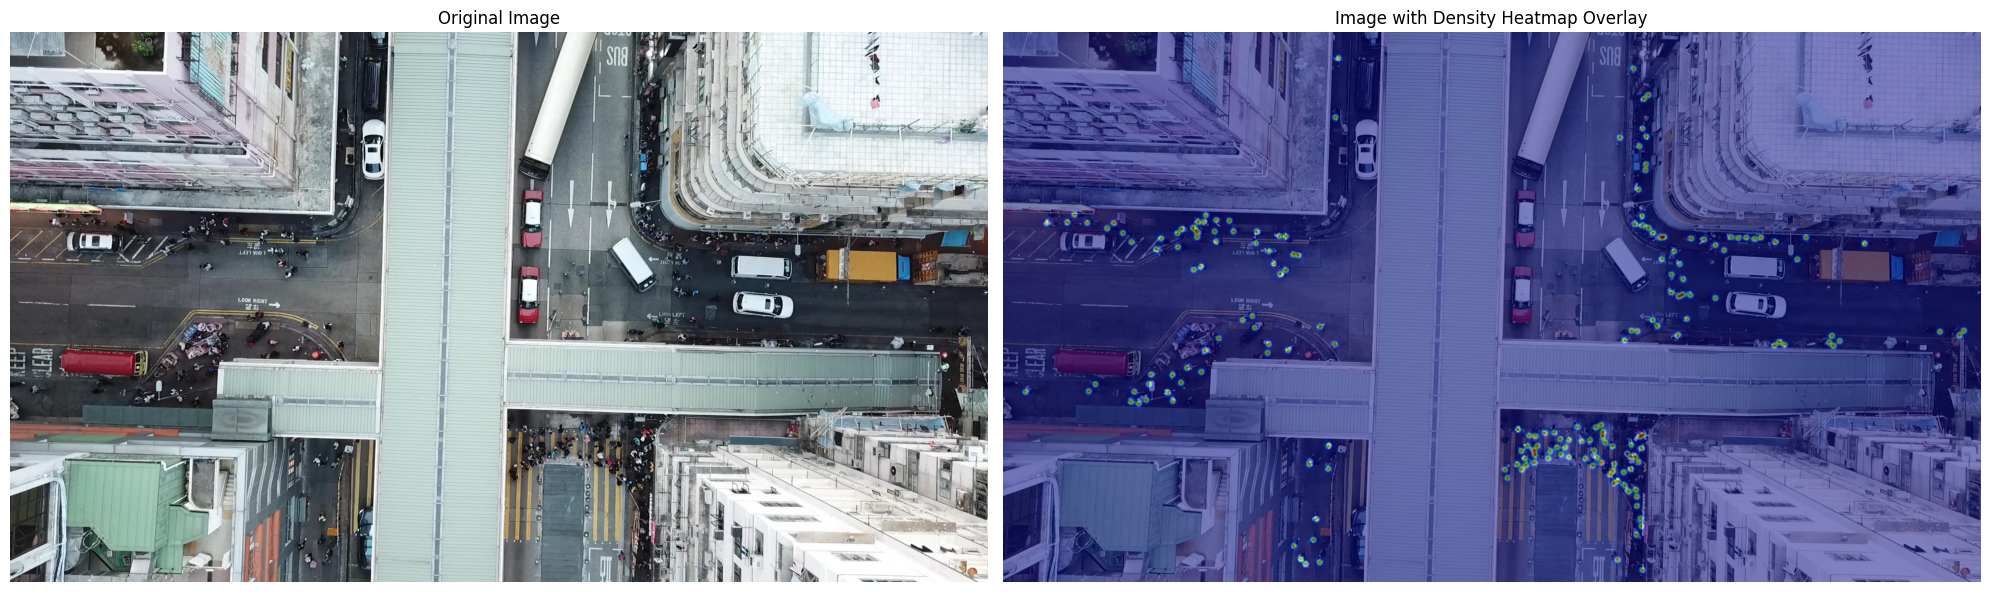

In [ ]:
import numpy as np
import h5py
import json
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image

# --- 1. 定义处理后数据集的路径 ---
PROCESSED_DATA_PATH = "/content/CSRNet-pytorch/preprocessed_VisDrone"

print(f"将从以下路径加载数据进行验证: {PROCESSED_DATA_PATH}")

# --- 2. 随机选择一个训练样本 ---
train_json_path = os.path.join(PROCESSED_DATA_PATH, "train.json")
if not os.path.exists(train_json_path):
    print(f"错误：找不到 train.json 文件。请确保预处理脚本已成功运行。")
else:
    with open(train_json_path, 'r') as f:
        train_file_list = json.load(f)

    if not train_file_list:
        print("错误：训练文件列表为空。")
    else:
        # 随机选择一张图片
        random_img_path = random.choice(train_file_list)

        # 构建对应的密度图路径
        random_gt_path = random_img_path.replace('images', 'ground_truth').replace('.jpg', '.h5')

        print(f"\n随机选择的图片: {os.path.basename(random_img_path)}")
        print(f"对应的密度图: {os.path.basename(random_gt_path)}")

        # --- 3. 加载图片和密度图 ---
        try:
            img = Image.open(random_img_path)
            with h5py.File(random_gt_path, 'r') as hf:
                density_map = np.asarray(hf['density'])

            print(f"图片加载成功，尺寸: {img.size}")
            print(f"密度图加载成功，形状: {density_map.shape}")
            print(f"密度图积分 (估算人数): {density_map.sum():.2f}")

            # --- 4. 可视化 ---
            plt.figure(figsize=(20, 12))

            # a) 显示原始图片
            plt.subplot(1, 2, 1)
            plt.imshow(img)
            plt.title('Original Image')
            plt.axis('off')

            # b) 显示叠加了热力图的图片
            plt.subplot(1, 2, 2)
            plt.imshow(img)
            # 将密度图归一化，以便更好地映射到颜色
            if density_map.max() > 0:
                density_map_normalized = density_map / density_map.max()
            else:
                density_map_normalized = density_map

            # 使用 'jet' colormap 生成热力图，并设置透明度 (alpha)
            plt.imshow(density_map_normalized, cmap=cm.jet, alpha=0.5)
            plt.title('Image with Density Heatmap Overlay')
            plt.axis('off')

            plt.tight_layout()
            plt.show()

        except FileNotFoundError:
            print(f"\n错误：找不到文件。请检查路径是否正确。")
            print(f"图片路径: {random_img_path}")
            print(f"密度图路径: {random_gt_path}")
        except Exception as e:
            print(f"\n发生了一个未知错误: {e}")

In [ ]:
import os
import glob
import re
from collections import defaultdict
import random
import json

# --- 1. 参数配置 ---
# 请确保这个路径是您存放预处理后数据的根目录
DATA_ROOT = '/content/CSRNet-pytorch/preprocessed_VisDrone'
VAL_SPLIT_RATIO = 0.2  # 分配 20% 的序列作为验证集

# --- 2. 路径定义 ---
IMAGE_DIR = os.path.join(DATA_ROOT, 'train_data', 'images')
NEW_TRAIN_JSON_PATH = os.path.join(DATA_ROOT, "Train.json")
NEW_VAL_JSON_PATH = os.path.join(DATA_ROOT, "Val.json")

print("🚀 开始进行序列感知的训练/验证集分割...")
print(f" searching for images in: {IMAGE_DIR}")

# --- 3. 扫描并按序列分组 ---
if not os.path.isdir(IMAGE_DIR):
    print(f"❌ 错误: 找不到图片目录 '{IMAGE_DIR}'。请检查 DATA_ROOT 路径是否正确。")
else:
    all_img_paths = sorted(glob.glob(os.path.join(IMAGE_DIR, '*.jpg')))

    if not all_img_paths:
        print(f"❌ 错误: 在目录 '{IMAGE_DIR}' 中没有找到任何 .jpg 图片。")
    else:
        print(f"  - 找到了 {len(all_img_paths)} 张总图片。")

        sequences = defaultdict(list)
        for path in all_img_paths:
            match = re.search(r'(\d+)_(\d+)\.jpg', os.path.basename(path))
            if match:
                seq_id = match.group(1)
                sequences[seq_id].append(path)

        print(f"  - 成功从文件名中解析出 {len(sequences)} 个独立的视频序列。")

        # --- 4. 分割序列ID ---
        all_seq_ids = sorted(sequences.keys())
        random.shuffle(all_seq_ids) # 随机打乱序列ID

        val_count = int(len(all_seq_ids) * VAL_SPLIT_RATIO)
        if val_count == 0 and len(all_seq_ids) > 0:
            val_count = 1 # 确保至少有一个序列在验证集中

        val_seq_ids = all_seq_ids[:val_count]
        train_seq_ids = all_seq_ids[val_count:]

        print(f"\n📊 分割结果:")
        print(f"  - {len(train_seq_ids)} 个序列用于训练。")
        print(f"  - {len(val_seq_ids)} 个序列用于验证。")

        # --- 5. 根据分割后的序列ID收集图片路径 ---
        train_paths = [path for seq_id in train_seq_ids for path in sequences[seq_id]]
        val_paths = [path for seq_id in val_seq_ids for path in sequences[seq_id]]

        # 再次打乱训练集中的帧顺序，这有助于提高训练效果
        random.shuffle(train_paths)

        print(f"  - {len(train_paths)} 张图片将被写入训练集。")
        print(f"  - {len(val_paths)} 张图片将被写入验证集。")

        # --- 6. 写入新的 JSON 文件 ---
        with open(NEW_TRAIN_JSON_PATH, 'w') as f:
            json.dump(train_paths, f)
        print(f"\n✅ 新的训练集文件 '{os.path.basename(NEW_TRAIN_JSON_PATH)}' 创建成功。")

        with open(NEW_VAL_JSON_PATH, 'w') as f:
            json.dump(val_paths, f)
        print(f"✅ 新的验证集文件 '{os.path.basename(NEW_VAL_JSON_PATH)}' 创建成功。")

🚀 开始进行序列感知的训练/验证集分割...
 searching for images in: /content/CSRNet-pytorch/preprocessed_VisDrone/train_data/images
  - 找到了 2460 张总图片。
  - 成功从文件名中解析出 82 个独立的视频序列。

📊 分割结果:
  - 66 个序列用于训练。
  - 16 个序列用于验证。
  - 1980 张图片将被写入训练集。
  - 480 张图片将被写入验证集。

✅ 新的训练集文件 'Train.json' 创建成功。
✅ 新的验证集文件 'Val.json' 创建成功。


# Version 1

## 训练

In [ ]:
!python /content/drive/MyDrive/VisDrone_human_detect/CSRNet-pytorch/train.py \
/content/CSRNet-pytorch/preprocessed_VisDrone/Train.json \
/content/CSRNet-pytorch/preprocessed_VisDrone/Val.json \
0 \
visdrone_run1

流式输出内容被截断，只能显示最后 5000 行内容。
Epoch: [78][3750/7872]	Time 0.030 (0.032)	Data 0.018 (0.019)	Loss 2.5317 (1.5317)	
Epoch: [78][3780/7872]	Time 0.032 (0.032)	Data 0.020 (0.019)	Loss 2.7990 (1.5331)	
Epoch: [78][3810/7872]	Time 0.032 (0.032)	Data 0.019 (0.019)	Loss 2.0908 (1.5322)	
Epoch: [78][3840/7872]	Time 0.033 (0.032)	Data 0.021 (0.019)	Loss 3.6801 (1.5345)	
Epoch: [78][3870/7872]	Time 0.032 (0.032)	Data 0.020 (0.019)	Loss 0.6398 (1.5312)	
Epoch: [78][3900/7872]	Time 0.032 (0.032)	Data 0.019 (0.019)	Loss 0.0524 (1.5321)	
Epoch: [78][3930/7872]	Time 0.032 (0.032)	Data 0.020 (0.019)	Loss 2.2978 (1.5338)	
Epoch: [78][3960/7872]	Time 0.032 (0.032)	Data 0.020 (0.019)	Loss 0.7962 (1.5352)	
Epoch: [78][3990/7872]	Time 0.032 (0.032)	Data 0.020 (0.019)	Loss 0.3360 (1.5360)	
Epoch: [78][4020/7872]	Time 0.032 (0.032)	Data 0.019 (0.019)	Loss 1.8402 (1.5386)	
Epoch: [78][4050/7872]	Time 0.032 (0.032)	Data 0.019 (0.019)	Loss 0.6998 (1.5370)	
Epoch: [78][4080/7872]	Time 0.030 (0.032)	Data 0.018 (0.019)

In [ ]:
import os
from google.colab import drive

# --- 1. 挂载 Google Drive ---
# 如果已经挂载，它会直接确认；否则会请求授权。
print("正在挂载 Google Drive...")
drive.mount('/content/drive')
print("✅ Google Drive 已成功挂载！")

# --- 2. 定义文件和目录 ---
# 根据 train.py 的默认行为，模型文件保存在项目根目录
SOURCE_DIR = "/content/"

# 你希望在 Google Drive 中保存模型的目标目录
# 脚本会自动创建这个目录，你可以按需修改
DESTINATION_DIR = "/content/drive/MyDrive/CSRNet_Models_Backup"

# 根据你的截图，这是要上传的文件名
files_to_upload = [
    "visdrone_run1checkpoint.pth.tar",
    "visdrone_run1model_best.pth.tar"
]

# --- 3. 创建目标目录 (如果不存在) ---
print(f"\n准备目标文件夹: {DESTINATION_DIR}")
os.makedirs(DESTINATION_DIR, exist_ok=True)
print("文件夹已就绪。")

# --- 4. 执行复制 ---
print("\n开始上传模型文件...")
for filename in files_to_upload:
    # 构造完整的源文件路径
    source_path = os.path.join(SOURCE_DIR, filename)

    # 检查文件是否存在，防止出错
    if os.path.exists(source_path):
        print(f"  > 正在复制 '{filename}'...")
        # 使用 Colab 的 shell 命令 `cp` 来执行复制，速度快且有反馈
        get_ipython().system(f"cp '{source_path}' '{DESTINATION_DIR}/'")
        print(f"  ✅ 文件成功复制到 Drive！")
    else:
        print(f"  ❌ 错误: 在 '{SOURCE_DIR}' 中未找到文件 '{filename}'。")
        print(f"     请确认训练时使用的 task name 是 'visdrone_run1'。")

print("\n--- 操作完成 ---")
print(f"如果上传成功，你现在应该可以在 Google Drive 的 '{DESTINATION_DIR}' 文件夹中看到你的模型文件了。")


正在挂载 Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive 已成功挂载！

准备目标文件夹: /content/drive/MyDrive/CSRNet_Models_Backup
文件夹已就绪。

开始上传模型文件...
  > 正在复制 'visdrone_run1checkpoint.pth.tar'...
  ✅ 文件成功复制到 Drive！
  > 正在复制 'visdrone_run1model_best.pth.tar'...
  ✅ 文件成功复制到 Drive！

--- 操作完成 ---
如果上传成功，你现在应该可以在 Google Drive 的 '/content/drive/MyDrive/CSRNet_Models_Backup' 文件夹中看到你的模型文件了。


## 测试

In [ ]:
!python /content/drive/MyDrive/VisDrone_human_detect/CSRNet-pytorch/inference.py \
    --model_path /content/drive/MyDrive/VisDrone_human_detect/CSRNet-pytorch/CSRNet_Models_Backup/visdrone_run1model_best.pth.tar \
    --test_json /content/CSRNet-pytorch/preprocessed_VisDrone/test.json \
    --output_dir /content/drive/MyDrive/VisDrone_human_detect/CSRNet-pytorch/predict/ \
    --gpu 0

--- Using GPU: 0 ---
Visualization images will be saved to: /content/drive/MyDrive/VisDrone_human_detect/CSRNet-pytorch/predict/
Loading model from /content/drive/MyDrive/VisDrone_human_detect/CSRNet-pytorch/CSRNet_Models_Backup/visdrone_run1model_best.pth.tar
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Found 900 images to process.

--- Starting Inference on All Test Images ---
[1/900] Image: 00011_00001.jpg, Predicted Coun

# Version 2

In [ ]:
!python /content/drive/MyDrive/VisDrone_human_detect/CSRNet-pytorch/train.py \
/content/CSRNet-pytorch/preprocessed_VisDrone/Train.json \
/content/CSRNet-pytorch/preprocessed_VisDrone/Val.json \
0 \
visdrone_version2

流式输出内容被截断，只能显示最后 5000 行内容。
Epoch: [86][5340/7872]	Time 0.033 (0.032)	Data 0.020 (0.019)	Loss 2.6373 (5.7621)	
Epoch: [86][5370/7872]	Time 0.032 (0.032)	Data 0.019 (0.019)	Loss 6.3199 (5.7662)	
Epoch: [86][5400/7872]	Time 0.035 (0.032)	Data 0.022 (0.019)	Loss 7.1974 (5.7744)	
Epoch: [86][5430/7872]	Time 0.034 (0.032)	Data 0.021 (0.019)	Loss 9.5020 (5.7756)	
Epoch: [86][5460/7872]	Time 0.032 (0.032)	Data 0.020 (0.019)	Loss 8.9878 (5.7748)	
Epoch: [86][5490/7872]	Time 0.032 (0.032)	Data 0.019 (0.019)	Loss 8.6055 (5.7705)	
Epoch: [86][5520/7872]	Time 0.032 (0.032)	Data 0.019 (0.019)	Loss 14.8353 (5.7656)	
Epoch: [86][5550/7872]	Time 0.032 (0.032)	Data 0.019 (0.019)	Loss 2.3697 (5.7627)	
Epoch: [86][5580/7872]	Time 0.031 (0.032)	Data 0.018 (0.019)	Loss 17.9111 (5.7604)	
Epoch: [86][5610/7872]	Time 0.032 (0.032)	Data 0.019 (0.019)	Loss 0.2428 (5.7665)	
Epoch: [86][5640/7872]	Time 0.032 (0.032)	Data 0.019 (0.019)	Loss 0.2303 (5.7709)	
Epoch: [86][5670/7872]	Time 0.032 (0.032)	Data 0.019 (0.01

# Version 3

## 实现多帧训练来捕捉时序信息

## 数据集读取并处理逻辑修改，同时接收并处理三帧图片

In [ ]:
!python /content/drive/MyDrive/VisDrone_human_detect/CSRNet-pytorch/train.py \
  --data_path /content/CSRNet-pytorch/preprocessed_VisDrone \
  --task visdrone_multifram_final \
  --batch_size 8 \
  --workers 2

INFO: Using random seed: 42
INFO: Initializing weights from pre-trained VGG16 on ImageNet...
INFO: Successfully loaded and adapted VGG16 weights for 9-channel input.
/usr/local/lib/python3.12/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
INFO: Successfully loaded dataset definitions.
INFO: 1980 images for training.
INFO: 480 images for validation.
Epoch: [0][0/248]	 Loss 171727056.0000
Epoch: [0][50/248]	 Loss 335642.7500
Epoch: [0][100/248]	 Loss 218323.5312
Epoch: [0][150/248]	 Loss 154012.4375
Epoch: [0][200/248]	 Loss 95052.6953
--- Starting validation ---
 * Validation MAE 676.911
 * New best MAE: 676.911!
 * Best MAE so far: 676.911. Early stopping: 0/50
Epoch: [1][0/248]	 Loss 61366.3281
Epoch: [1][50/248]	 Loss 28735.1484
Epoch: [1][100/248]	 Loss 17372.8828
Epoch: [1][150/248]	 Loss 11503.0059
Epoch: [1][200/248]	 Loss 10312.7520
--- Starting valida

In [ ]:
import os
from google.colab import drive

# --- 1. 挂载 Google Drive ---
# 如果已经挂载，它会直接确认；否则会请求授权。
print("正在挂载 Google Drive...")
drive.mount('/content/drive')
print("✅ Google Drive 已成功挂载！")

# --- 2. 定义文件和目录 ---
# 根据 train.py 的默认行为，模型文件保存在项目根目录
SOURCE_DIR = "/content/"

# 你希望在 Google Drive 中保存模型的目标目录
# 脚本会自动创建这个目录，你可以按需修改
DESTINATION_DIR = "/content/drive/MyDrive/CSRNet_Models_Backup"

# 根据你的截图，这是要上传的文件名
files_to_upload = [
    "visdrone_multifram_finalcheckpoint.pth.tar",
    "visdrone_multifram_finalmodel_best.pth.tar"
]

# --- 3. 创建目标目录 (如果不存在) ---
print(f"\n准备目标文件夹: {DESTINATION_DIR}")
os.makedirs(DESTINATION_DIR, exist_ok=True)
print("文件夹已就绪。")

# --- 4. 执行复制 ---
print("\n开始上传模型文件...")
for filename in files_to_upload:
    # 构造完整的源文件路径
    source_path = os.path.join(SOURCE_DIR, filename)

    # 检查文件是否存在，防止出错
    if os.path.exists(source_path):
        print(f"  > 正在复制 '{filename}'...")
        # 使用 Colab 的 shell 命令 `cp` 来执行复制，速度快且有反馈
        get_ipython().system(f"cp '{source_path}' '{DESTINATION_DIR}/'")
        print(f"  ✅ 文件成功复制到 Drive！")
    else:
        print(f"  ❌ 错误: 在 '{SOURCE_DIR}' 中未找到文件 '{filename}'。")
        print(f"     请确认训练时使用的 task name 是 'visdrone_run1'。")

print("\n--- 操作完成 ---")
print(f"如果上传成功，你现在应该可以在 Google Drive 的 '{DESTINATION_DIR}' 文件夹中看到你的模型文件了。")


正在挂载 Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive 已成功挂载！

准备目标文件夹: /content/drive/MyDrive/CSRNet_Models_Backup
文件夹已就绪。

开始上传模型文件...
  > 正在复制 'visdrone_multifram_finalcheckpoint.pth.tar'...
  ✅ 文件成功复制到 Drive！
  > 正在复制 'visdrone_multifram_finalmodel_best.pth.tar'...
  ✅ 文件成功复制到 Drive！

--- 操作完成 ---
如果上传成功，你现在应该可以在 Google Drive 的 '/content/drive/MyDrive/CSRNet_Models_Backup' 文件夹中看到你的模型文件了。


In [ ]:
!python /content/drive/MyDrive/VisDrone_human_detect/CSRNet-pytorch/inference.py \
    --model_path /content/drive/MyDrive/VisDrone_human_detect/CSRNet-pytorch/CSRNet_Models_Backup/CSRNet_Models_Backup/visdrone_multifram_finalmodel_best.pth.tar \
    --input_json /content/CSRNet-pytorch/preprocessed_VisDrone/test.json \
    --output_dir /content/drive/MyDrive/VisDrone_human_detect/CSRNet-pytorch/predict/multiframe/ \
    --num_visualizations 10

✅ 推理设备: cuda
✅ 可视化结果将保存至: /content/drive/MyDrive/VisDrone_human_detect/CSRNet-pytorch/predict/multiframe/

🚀 正在加载模型...
INFO: Initializing weights from pre-trained VGG16 on ImageNet...
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100% 528M/528M [00:02<00:00, 219MB/s]
INFO: Successfully loaded and adapted VGG16 weights for 9-channel input.
✅ 模型成功从 '/content/drive/MyDrive/VisDrone_human_detect/CSRNet-pytorch/CSRNet_Models_Backup/CSRNet_Models_Backup/visdrone_multifram_finalmodel_best.pth.tar' 加载。
✅ 成功从 '/content/CSRNet-pytorch/preprocessed_VisDrone/test.json' 加载 900 张图片路径。

🧠 开始批量推理...
  [1/900] 图片: 00011_00001.jpg, 预测人数: 178.66
  [2/900] 图片: 00011_00002.jpg, 预测人数: 189.37
  [3/900] 图片: 00011_00003.jpg, 预测人数: 189.28
  [4/900] 图片: 00011_00004.jpg, 预测人数: 183.38
  [5/900] 图片: 00011_00005.jpg, 预测人数: 186.26
  [6/900] 图片: 00011_00006.jpg, 预测人数: 189.97
  [7/900] 图片: 00011_00007.jpg, 预测人数: 199.38
  [8/900] 图片: 00011_

## 验证集对比实验

### 优化前

In [ ]:
!python /content/drive/MyDrive/VisDrone_human_detect/CSRNet-pytorch/inference_CRSNet.py \
    --model_path /content/drive/MyDrive/VisDrone_human_detect/CSRNet-pytorch/CSRNet_Models_Backup/visdrone_run1model_best.pth.tar \
    --test_json /content/CSRNet-pytorch/preprocessed_VisDrone/Val.json \
    --output_dir /content/drive/MyDrive/VisDrone_human_detect/CSRNet-pytorch/predict/ \
    --gpu 0

--- Using GPU: 0 ---
Visualization images will be saved to: /content/drive/MyDrive/VisDrone_human_detect/CSRNet-pytorch/predict/
Loading model from /content/drive/MyDrive/VisDrone_human_detect/CSRNet-pytorch/CSRNet_Models_Backup/visdrone_run1model_best.pth.tar
Found 480 images to process.

--- Starting Inference on All Test Images ---
[1/480] Image: 00026_00001.jpg, Predicted Count: 143.34
[2/480] Image: 00026_00002.jpg, Predicted Count: 143.19
[3/480] Image: 00026_00003.jpg, Predicted Count: 143.60
[4/480] Image: 00026_00004.jpg, Predicted Count: 145.94
[5/480] Image: 00026_00005.jpg, Predicted Count: 145.30
[6/480] Image: 00026_00006.jpg, Predicted Count: 148.16
[7/480] Image: 00026_00007.jpg, Predicted Count: 154.17
[8/480] Image: 00026_00008.jpg, Predicted Count: 150.59
[9/480] Image: 00026_00009.jpg, Predicted Count: 150.71
[10/480] Image: 00026_00010.jpg, Predicted Count: 150.11
[11/480] Image: 00026_00011.jpg, Predicted Count: 149.10
[12/480] Image: 00026_00012.jpg, Predicted Co

### 优化后

In [ ]:
!python /content/drive/MyDrive/VisDrone_human_detect/CSRNet-pytorch/inference.py \
    --model_path /content/drive/MyDrive/VisDrone_human_detect/CSRNet-pytorch/CSRNet_Models_Backup/CSRNet_Models_Backup/visdrone_multifram_finalmodel_best.pth.tar \
    --input_json /content/CSRNet-pytorch/preprocessed_VisDrone/Val.json \
    --output_dir /content/drive/MyDrive/VisDrone_human_detect/CSRNet-pytorch/predict/multiframe/ \
    --num_visualizations 10

✅ 推理设备: cuda
✅ 可视化结果将保存至: /content/drive/MyDrive/VisDrone_human_detect/CSRNet-pytorch/predict/multiframe/

🚀 正在加载模型...
INFO: Initializing weights from pre-trained VGG16 on ImageNet...
INFO: Successfully loaded and adapted VGG16 weights for 9-channel input.
✅ 模型成功从 '/content/drive/MyDrive/VisDrone_human_detect/CSRNet-pytorch/CSRNet_Models_Backup/CSRNet_Models_Backup/visdrone_multifram_finalmodel_best.pth.tar' 加载。
✅ 成功从 '/content/CSRNet-pytorch/preprocessed_VisDrone/Val.json' 加载 480 张图片路径。

🧠 开始批量推理...
  [1/480] 图片: 00026_00001.jpg, 预测人数: 156.17
  [2/480] 图片: 00026_00002.jpg, 预测人数: 158.90
  [3/480] 图片: 00026_00003.jpg, 预测人数: 157.85
  [4/480] 图片: 00026_00004.jpg, 预测人数: 155.33
  [5/480] 图片: 00026_00005.jpg, 预测人数: 161.08
  [6/480] 图片: 00026_00006.jpg, 预测人数: 161.61
  [7/480] 图片: 00026_00007.jpg, 预测人数: 159.31
  [8/480] 图片: 00026_00008.jpg, 预测人数: 158.90
  [9/480] 图片: 00026_00009.jpg, 预测人数: 156.03
  [10/480] 图片: 00026_00010.jpg, 预测人数: 162.13
  [11/480] 图片: 00026_00011.jpg, 预测人数: 168.54
  [12/48

In [ ]:
import json
import os
import re
from collections import defaultdict

def get_ground_truth_counts():
    """
    Reads a JSON file of image paths, finds the corresponding original VisDrone
    annotation files, and counts the number of people in each specified frame.
    """
    val_json_path = '/content/CSRNet-pytorch/preprocessed_VisDrone/Val.json'
    annotations_dir = '/content/VisDrone2020-CC/annotations/'

    print(f"--- Reading validation image list from: {val_json_path} ---")

    try:
        with open(val_json_path, 'r') as f:
            image_paths = json.load(f)
    except FileNotFoundError:
        print(f"❌ ERROR: Cannot find the validation JSON file at '{val_json_path}'. Please check the path.")
        return
    except json.JSONDecodeError:
        print(f"❌ ERROR: The file at '{val_json_path}' is not a valid JSON file.")
        return

    # --- 为了效率，预加载所有相关的标注文件 ---
    # 1. 找出所有需要的序列ID
    required_seq_ids = set()
    for img_path in image_paths:
        match = re.search(r'(\d+)_(\d+)\.jpg', os.path.basename(img_path))
        if match:
            seq_id = match.group(1)
            required_seq_ids.add(seq_id)

    # 2. 读取并解析所有需要的标注文件，存入一个字典
    # 结构: { 'seq_id': { 'frame_num': count, ... }, ... }
    annotations_cache = defaultdict(lambda: defaultdict(int))
    print(f"\n--- Pre-loading annotations for {len(required_seq_ids)} sequences... ---")

    for seq_id in sorted(list(required_seq_ids)):
        annotation_file_path = os.path.join(annotations_dir, f"{seq_id}.txt")
        try:
            with open(annotation_file_path, 'r') as f:
                for line in f:
                    parts = line.strip().split(',')
                    if len(parts) >= 2:
                        frame_index = int(parts[0])
                        # 每有一行对应这个frame, 计数值就+1
                        annotations_cache[seq_id][frame_index] += 1
        except FileNotFoundError:
            print(f"  - Warning: Annotation file not found for sequence {seq_id} at '{annotation_file_path}'. Skipping.")
            continue

    print("--- Annotation loading complete. ---\n")

    # --- 逐一查找并打印每张图片的真实人数 ---
    print("--- Ground Truth Counts for Each Image in Val.json ---")
    total_images = len(image_paths)
    for i, img_path in enumerate(image_paths):
        img_name = os.path.basename(img_path)
        match = re.search(r'(\d+)_(\d+)\.jpg', img_name)

        if not match:
            print(f"[{i+1}/{total_images}] {img_name}:  - SKIPPED (Filename format incorrect)")
            continue

        seq_id, frame_num_str = match.groups()
        frame_num = int(frame_num_str)

        # 从缓存中直接读取计数值
        count = annotations_cache[seq_id].get(frame_num, 0)

        print(f"[{i+1}/{total_images}] {img_name}:  Ground Truth = {count}")

# --- 运行函数 ---
get_ground_truth_counts()

--- Reading validation image list from: /content/CSRNet-pytorch/preprocessed_VisDrone/Val.json ---

--- Pre-loading annotations for 16 sequences... ---
--- Annotation loading complete. ---

--- Ground Truth Counts for Each Image in Val.json ---
[1/480] 00026_00001.jpg:  Ground Truth = 147
[2/480] 00026_00002.jpg:  Ground Truth = 144
[3/480] 00026_00003.jpg:  Ground Truth = 145
[4/480] 00026_00004.jpg:  Ground Truth = 144
[5/480] 00026_00005.jpg:  Ground Truth = 146
[6/480] 00026_00006.jpg:  Ground Truth = 149
[7/480] 00026_00007.jpg:  Ground Truth = 149
[8/480] 00026_00008.jpg:  Ground Truth = 150
[9/480] 00026_00009.jpg:  Ground Truth = 149
[10/480] 00026_00010.jpg:  Ground Truth = 148
[11/480] 00026_00011.jpg:  Ground Truth = 149
[12/480] 00026_00012.jpg:  Ground Truth = 148
[13/480] 00026_00013.jpg:  Ground Truth = 147
[14/480] 00026_00014.jpg:  Ground Truth = 147
[15/480] 00026_00015.jpg:  Ground Truth = 144
[16/480] 00026_00016.jpg:  Ground Truth = 146
[17/480] 00026_00017.jpg:  G